In [16]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

### Read Data

In [13]:
%%time
paths=[]
for name in glob('medium_archive/*',recursive=True):
    paths.append(name)  
    
    
img_paths=[]
extra_paths=[]
for i in paths:
    for name in glob(i+'/*'):
        if name.endswith('.png'):
            a=name.split('/')
            img_paths.append([name,a[-2]])
        else:
            extra_paths.append(name) 
            

extra_imgs=[]
for i in extra_paths:
    if i=='medium_archive/Apple/Total Number of Apples':
        for name in glob(i+'/*'):
            if name.endswith('.png'):
                extra_imgs.append([name,'Apple'])
    elif i=='medium_archive/Guava/guava total final':
        for name in glob(i+'/*'):
            if name.endswith('.png'):
                extra_imgs.append([name,'Guava'])
    elif i=='medium_archive/Kiwi/Total Number of Kiwi fruit':
        for name in glob(i+'/*'):
            if name.endswith('.png'):
                extra_imgs.append([name,'Kiwi']) 
                

img_final=img_paths+extra_imgs 

labels=[]
for i in range(len(img_final)):
    labels.append(img_final[i][1])
    img_final[i]=img_final[i][0] 
    
img_path = pd.Series(img_final).astype(str)  

labels=pd.Series(labels)
data = pd.concat([img_path,labels],axis=1)

CPU times: user 99.5 ms, sys: 28.4 ms, total: 128 ms
Wall time: 141 ms


In [5]:
data

,0,1
0,medium_archive/Pitaya/Pitaya00296.png,Pitaya
1,medium_archive/Pitaya/Pitaya00282.png,Pitaya
2,medium_archive/Pitaya/Pitaya00269.png,Pitaya
3,medium_archive/Pitaya/Pitaya00255.png,Pitaya
4,medium_archive/Pitaya/Pitaya00533.png,Pitaya
...,...,...
17971,medium_archive/Guava/guava total final/Guava06...,Guava
17972,medium_archive/Guava/guava total final/Guava08...,Guava
17973,medium_archive/Guava/guava total final/Guava06...,Guava
17974,medium_archive/Guava/guava total final/Guava08...,Guava


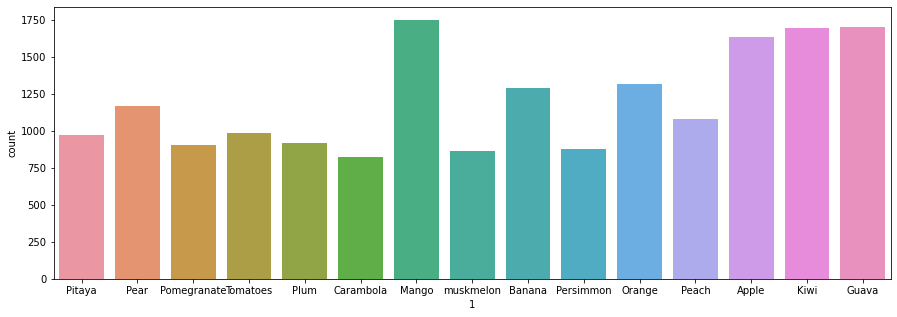

In [7]:
plt.figure(figsize=(15,5))
sns.countplot(x=data[1])

In [10]:
train_set.shape,test_set.shape

((14380, 2), (3596, 2))

In [12]:
pd.set_option('display.max_colwidth', None)
data.describe()

,0,1
count,17976,17976
unique,17976,15
top,medium_archive/Apple/Total Number of Apples/Apple 01011.png,Mango
freq,1,1750


### Construct training, validation, and test data set

In [23]:
%%time
train_set , test_set = train_test_split(data,test_size=0.2,random_state=17)
train_gen = ImageDataGenerator(validation_split=0.1)
test_gen = ImageDataGenerator()

train_data = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training'
)

val_data = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    subset = 'validation'
)

test_data = test_gen.flow_from_dataframe(
    dataframe = test_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False
)

Found 12942 validated image filenames belonging to 15 classes.
Found 1438 validated image filenames belonging to 15 classes.
Found 3596 validated image filenames belonging to 15 classes.
CPU times: user 364 ms, sys: 163 ms, total: 528 ms
Wall time: 692 ms


### Build Sequential models

In [14]:
%%time
# We will be using Sequential() for image classification here.
# The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) 
# with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. 
# There's a fully-connected layer (tf.keras.layers.Dense) with 256 units on top of it 
# that is activated by a ReLU activation function ('relu'). 
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)), 
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(15, activation='softmax')
])
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='categorical_crossentropy',
    metrics=['accuracy','Recall']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

/Users/xiaoyulin/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
history = model.fit(train_data,epochs=40,validation_data=val_data)

Epoch 1/40
405/405 [==============================] - 454s 1s/step - loss: 4.4190 - accuracy: 0.1157 - recall: 0.0658 - val_loss: 2.0986 - val_accuracy: 0.3512 - val_recall: 0.0828
Epoch 2/40
405/405 [==============================] - 445s 1s/step - loss: 3.2996 - accuracy: 0.2031 - recall: 0.1193 - val_loss: 1.7521 - val_accuracy: 0.4680 - val_recall: 0.1898
Epoch 3/40
405/405 [==============================] - 449s 1s/step - loss: 2.6968 - accuracy: 0.2874 - recall: 0.1750 - val_loss: 1.5270 - val_accuracy: 0.5466 - val_recall: 0.2789
Epoch 4/40
405/405 [==============================] - 446s 1s/step - loss: 2.2916 - accuracy: 0.3549 - recall: 0.2262 - val_loss: 1.3666 - val_accuracy: 0.6085 - val_recall: 0.3588
Epoch 5/40
405/405 [==============================] - 450s 1s/step - loss: 2.0018 - accuracy: 0.4157 - recall: 0.2760 - val_loss: 1.2181 - val_accuracy: 0.6516 - val_recall: 0.4172
Epoch 6/40
405/405 [==============================] - 450s 1s/step - loss: 1.7736 - accuracy: 0

In [ ]:
##############################

In [24]:
# Change the activation function to softmax
model_2 = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),  input_shape=(227,227,3)),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)), 
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(15, activation='softmax')
])
model_2.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='categorical_crossentropy',
    metrics=['accuracy','Recall']
)

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 55, 55, 96)        0         
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 27, 27, 256)       0

/Users/xiaoyulin/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
history_2 = model_2.fit(train_data,epochs=40,validation_data=val_data)

Epoch 1/40
405/405 [==============================] - 487s 1s/step - loss: 4.0362 - accuracy: 0.1531 - recall: 0.1034 - val_loss: 1.6930 - val_accuracy: 0.4597 - val_recall: 0.1864
Epoch 2/40
405/405 [==============================] - 476s 1s/step - loss: 2.6980 - accuracy: 0.2992 - recall: 0.2122 - val_loss: 1.2438 - val_accuracy: 0.6259 - val_recall: 0.3950
Epoch 3/40
405/405 [==============================] - 526s 1s/step - loss: 2.0248 - accuracy: 0.4213 - recall: 0.3250 - val_loss: 0.9907 - val_accuracy: 0.7128 - val_recall: 0.5278
Epoch 4/40
405/405 [==============================] - 532s 1s/step - loss: 1.6237 - accuracy: 0.5163 - recall: 0.4195 - val_loss: 0.8328 - val_accuracy: 0.7524 - val_recall: 0.6092
Epoch 5/40
405/405 [==============================] - 494s 1s/step - loss: 1.3504 - accuracy: 0.5794 - recall: 0.4871 - val_loss: 0.7169 - val_accuracy: 0.7851 - val_recall: 0.6739
Epoch 6/40
405/405 [==============================] - 481s 1s/step - loss: 1.1783 - accuracy: 0

In [ ]:
########################################

In [26]:
# Change optimizer to SGD
model_3 = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)), 
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(15, activation='softmax')
])
model_3.compile(
    optimizer=tf.optimizers.SGD(lr=0.000001),
    loss='categorical_crossentropy',
    metrics=['accuracy','Recall']
)

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 55, 55, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                      

/Users/xiaoyulin/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [27]:
history_3 = model_3.fit(train_data,epochs=40,validation_data=val_data)

Epoch 1/40
405/405 [==============================] - 429s 1s/step - loss: 5.6780 - accuracy: 0.0811 - recall: 0.0429 - val_loss: 3.2300 - val_accuracy: 0.0765 - val_recall: 6.9541e-04
Epoch 2/40
405/405 [==============================] - 430s 1s/step - loss: 5.4971 - accuracy: 0.0759 - recall: 0.0386 - val_loss: 3.2023 - val_accuracy: 0.0772 - val_recall: 0.0014
Epoch 3/40
405/405 [==============================] - 427s 1s/step - loss: 5.3412 - accuracy: 0.0785 - recall: 0.0414 - val_loss: 3.0670 - val_accuracy: 0.0897 - val_recall: 0.0021
Epoch 4/40
405/405 [==============================] - 429s 1s/step - loss: 5.1784 - accuracy: 0.0817 - recall: 0.0419 - val_loss: 2.9836 - val_accuracy: 0.1057 - val_recall: 0.0021
Epoch 5/40
405/405 [==============================] - 440s 1s/step - loss: 5.1053 - accuracy: 0.0811 - recall: 0.0420 - val_loss: 2.9388 - val_accuracy: 0.1085 - val_recall: 0.0035
Epoch 6/40
405/405 [==============================] - 438s 1s/step - loss: 5.0576 - accurac

### Visualize the result

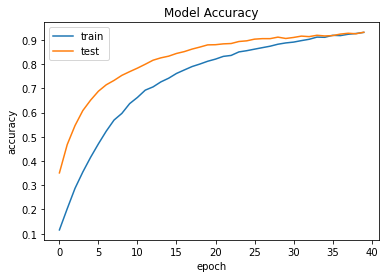

In [16]:
import matplotlib.pyplot as plt
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

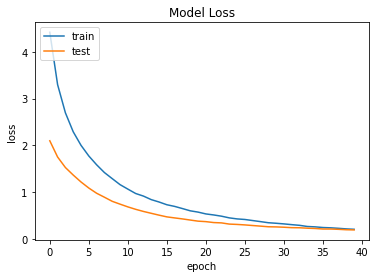

In [17]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred,axis=1)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# print the classification report
print(classification_report(test_data.labels,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       331
           1       0.85      0.95      0.90       265
           2       0.99      0.95      0.97       144
           3       0.94      0.94      0.94       353
           4       0.95      0.99      0.97       342
           5       0.96      0.93      0.94       351
           6       0.97      1.00      0.98       262
           7       0.91      0.93      0.92       224
           8       1.00      0.99      0.99       220
           9       0.99      0.96      0.97       182
          10       1.00      1.00      1.00       174
          11       1.00      0.99      0.99       192
          12       0.90      0.81      0.86       187
          13       0.93      0.96      0.94       206
          14       0.84      0.93      0.88       163

    accuracy                           0.94      3596
   macro avg       0.94      0.94      0.94      3596
weighted avg       0.94   

In [21]:
classes=[i for i in range(15)]
con_mat_df = pd.DataFrame(confusion_matrix(test_data.labels,y_pred),
                     index = classes, 
                     columns = classes)

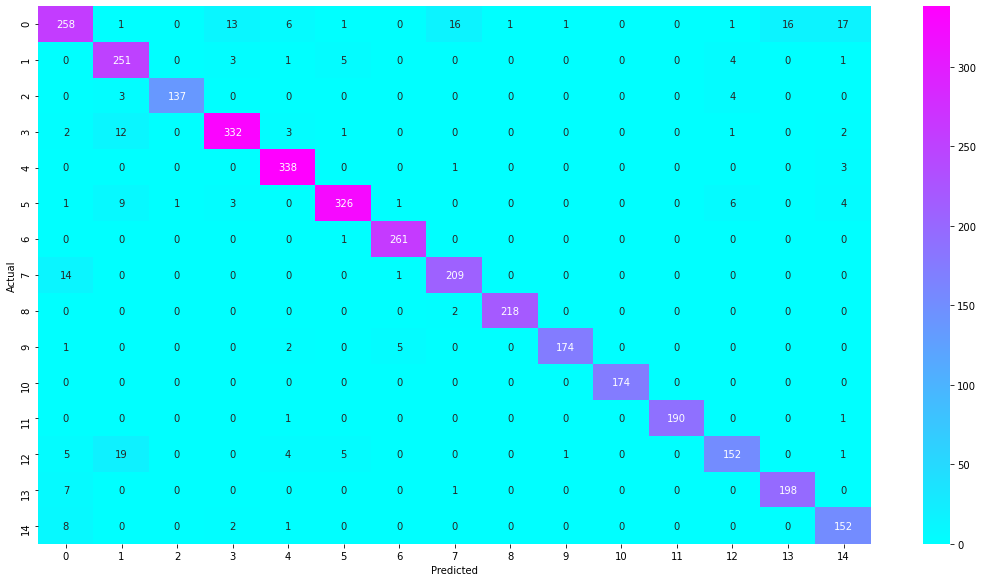

In [22]:
import seaborn as sns
figure = plt.figure(figsize=(15, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()